# Tic-Tac-Toe RL with Position Analysis

Complete analysis of learning rates AND position advantage (X first vs second).

## 1. Import Dependencies

In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
from agents import Agent, Teacher, Human
from game_logic import play, PLAYER_X, PLAYER_O
from measure_with_random import measure_performance_vs_random

# Set up matplotlib for inline plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

## 2. Helper Functions

In [2]:
def evaluate_x_as_second(x_agent, games=100):
    """Evaluate X strategy when playing second position (as O vs random X)"""
    # Create X-strategy playing as O
    x_as_o = Agent(PLAYER_O, learning=False)
    x_as_o.values = x_agent.values.copy()
    x_as_o.epsilon = 0  # Pure exploitation
    
    # Random opponent playing first as X
    random_x = Agent(PLAYER_X, learning=False)
    random_x.epsilon = 1  # Pure random - SET AFTER CREATION
    
    wins = sum(1 for _ in range(games) if play(random_x, x_as_o) == PLAYER_O)
    return wins / games

def evaluate_o_as_first(o_agent, games=100):
    """Evaluate O strategy when playing first position (as X vs random O)"""
    # Create O-strategy playing as X
    o_as_x = Agent(PLAYER_X, learning=False)
    o_as_x.values = o_agent.values.copy()
    o_as_x.epsilon = 0  # Pure exploitation
    
    # Random opponent playing second as O
    random_o = Agent(PLAYER_O, learning=False)
    random_o.epsilon = 1  # Pure random - SET AFTER CREATION
    
    wins = sum(1 for _ in range(games) if play(o_as_x, random_o) == PLAYER_X)
    return wins / games

## 3. Training Function with Position Tracking

In [3]:
def run_experiment_with_alpha(alpha_value, episodes=10000):
    """Run training experiment with alpha value AND position tracking for BOTH agents"""
    print(f"\n=== Running experiment with alpha = {alpha_value} ===")
    
    # Create agents with specified alpha
    p1 = Agent(PLAYER_X, lossval=-1, alpha=alpha_value)
    p2 = Agent(PLAYER_O, lossval=-1, alpha=alpha_value)
    teacher_o = Teacher(level=0.9)
    teacher_x = Teacher(level=0.9)
    
    # Track data - 10 arrays: episodes, p1-win, p1-lose, p1-draw, p2-win, p2-lose, p2-draw, x-second-rate, o-first-rate, o-normal-rate
    perf = [[] for _ in range(10)]
    training_episodes = []
    agent1_training_wins = []
    agent2_training_wins = []
    agent1_recent_results = []
    agent2_recent_results = []
    
    for i in range(episodes):
        # STEP 1: TRAINING FIRST
        if i % 2 == 0:
            winner = play(p1, teacher_o)
            p1.episode_over(winner)
            agent1_recent_results.append(winner)
        else:
            winner = play(teacher_x, p2)
            p2.episode_over(winner)
            agent2_recent_results.append(winner)
        
        # STEP 2: EVALUATION AFTER TRAINING (every 10 episodes)
        if i % 10 == 0:
            if i % 1000 == 0:
                print(f'Episode: {i}')
            
            # Standard evaluation: p1 vs random, random vs p2
            probs = measure_performance_vs_random(p1, p2, games=100)
            
            # NEW: Position evaluations
            x_second_rate = evaluate_x_as_second(p1, games=100)  # X strategy as second
            o_first_rate = evaluate_o_as_first(p2, games=100)    # O strategy as first
            
            # Store all data
            perf[0].append(i)  # episodes
            for idx, x in enumerate(probs):
                perf[idx + 1].append(x)  # indices 1-6: standard evaluation
            perf[7].append(x_second_rate)  # index 7: X-as-second evaluation
            perf[8].append(o_first_rate)   # index 8: O-as-first evaluation
            perf[9].append(probs[3])       # index 9: O normal (second) - duplicate of probs[3] for comparison
        
        # Track training vs teacher every 1000 episodes
        if i % 1000 == 0:
            training_episodes.append(i)
            if agent1_recent_results:
                agent1_wins = sum(1 for w in agent1_recent_results if w == PLAYER_X)
                agent1_training_wins.append(agent1_wins / len(agent1_recent_results))
            else:
                agent1_training_wins.append(0)
                
            if agent2_recent_results:
                agent2_wins = sum(1 for w in agent2_recent_results if w == PLAYER_O)
                agent2_training_wins.append(agent2_wins / len(agent2_recent_results))
            else:
                agent2_training_wins.append(0)
            
            agent1_recent_results = []
            agent2_recent_results = []
    
    return {
        'alpha': alpha_value,
        'evaluation_data': perf,
        'training_episodes': training_episodes,
        'agent1_training_wins': agent1_training_wins,
        'agent2_training_wins': agent2_training_wins,
        'trained_agents': (p1, p2)
    }

## 4. Run Experiments

In [4]:
# Run alpha comparison experiments WITH position tracking
alpha_values = [0.01, 0.1, 0.5, 0.99]
all_results = {}

print("Starting Alpha Comparison with Position Analysis...")
for alpha in alpha_values:
    results = run_experiment_with_alpha(alpha)
    all_results[alpha] = results
    
print("\n✅ All experiments completed!")

Starting Alpha Comparison with Position Analysis...

=== Running experiment with alpha = 0.01 ===
Episode: 0
Episode: 1000
Episode: 2000
Episode: 3000
Episode: 4000
Episode: 5000
Episode: 6000
Episode: 7000
Episode: 8000
Episode: 9000

=== Running experiment with alpha = 0.1 ===
Episode: 0
Episode: 1000
Episode: 2000
Episode: 3000
Episode: 4000
Episode: 5000
Episode: 6000
Episode: 7000
Episode: 8000
Episode: 9000

=== Running experiment with alpha = 0.5 ===
Episode: 0
Episode: 1000
Episode: 2000
Episode: 3000
Episode: 4000
Episode: 5000
Episode: 6000
Episode: 7000
Episode: 8000
Episode: 9000

=== Running experiment with alpha = 0.99 ===
Episode: 0
Episode: 1000
Episode: 2000
Episode: 3000
Episode: 4000
Episode: 5000
Episode: 6000
Episode: 7000
Episode: 8000
Episode: 9000

✅ All experiments completed!


## 5. Agent1(X) vs Random 
Player was trained as X
First Player (X) vs Second Player (O) (Red Line)
First Player (O) vs Second Player (X) (Green Line)

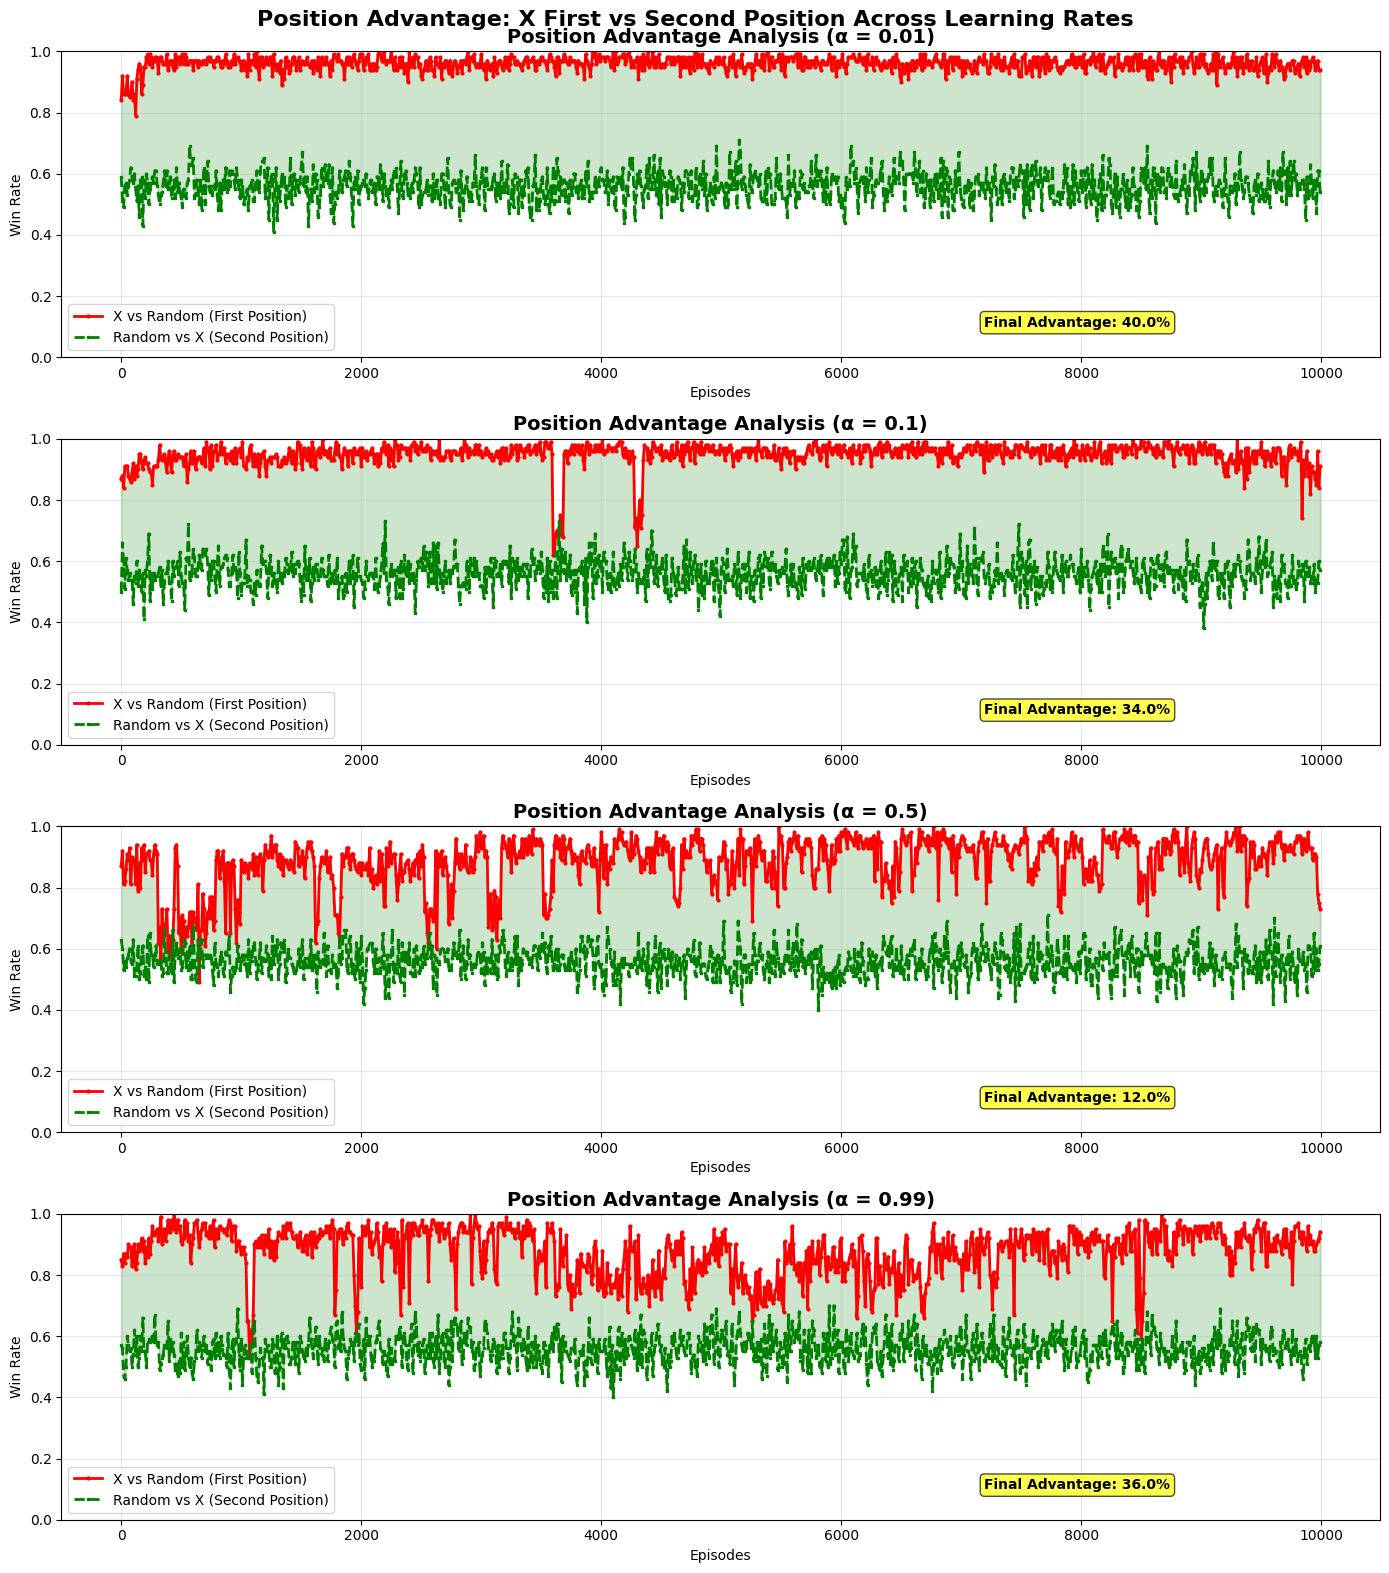

In [5]:
# Agent1(X) Position Comparison: First vs Second
fig1, ax1 = plt.subplots(4, 1, figsize=(14, 16))

for row, alpha in enumerate(alpha_values):
    data = all_results[alpha]['evaluation_data']
    
    # Red line: X playing first position
    ax1[row].plot(data[0], data[1], color='red', linewidth=2, 
                  label='X vs Random (First Position)', marker='o', markersize=2)
    
    # Blue line: X strategy playing second position  
    ax1[row].plot(data[0], data[7], color='green', linewidth=2, linestyle='--',
                  label='Random vs X (Second Position)', marker='s', markersize=2)
    
    # Fill area to show advantage
    ax1[row].fill_between(data[0], data[1], data[7], alpha=0.2, color='green')
    
    ax1[row].set_title(f'Position Advantage Analysis (α = {alpha})', fontsize=14, fontweight='bold')
    ax1[row].set_xlabel('Episodes')
    ax1[row].set_ylabel('Win Rate')
    ax1[row].grid(True, alpha=0.3)
    ax1[row].set_ylim(0, 1)
    ax1[row].legend()
    
    # Add final advantage annotation
    final_first = data[1][-1]
    final_second = data[7][-1]
    advantage = final_first - final_second
    
    ax1[row].annotate(f'Final Advantage: {advantage:.1%}', 
                     xy=(0.7, 0.1), xycoords='axes fraction',
                     bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                     fontsize=10, fontweight='bold')

plt.suptitle('Position Advantage: X First vs Second Position Across Learning Rates', 
            fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Agent2(O) vs Random 

Player was trained as O
First Player (X) vs Second Player (O) (Blue Line)
First Player (O) vs Second Player (X) (Green Line)


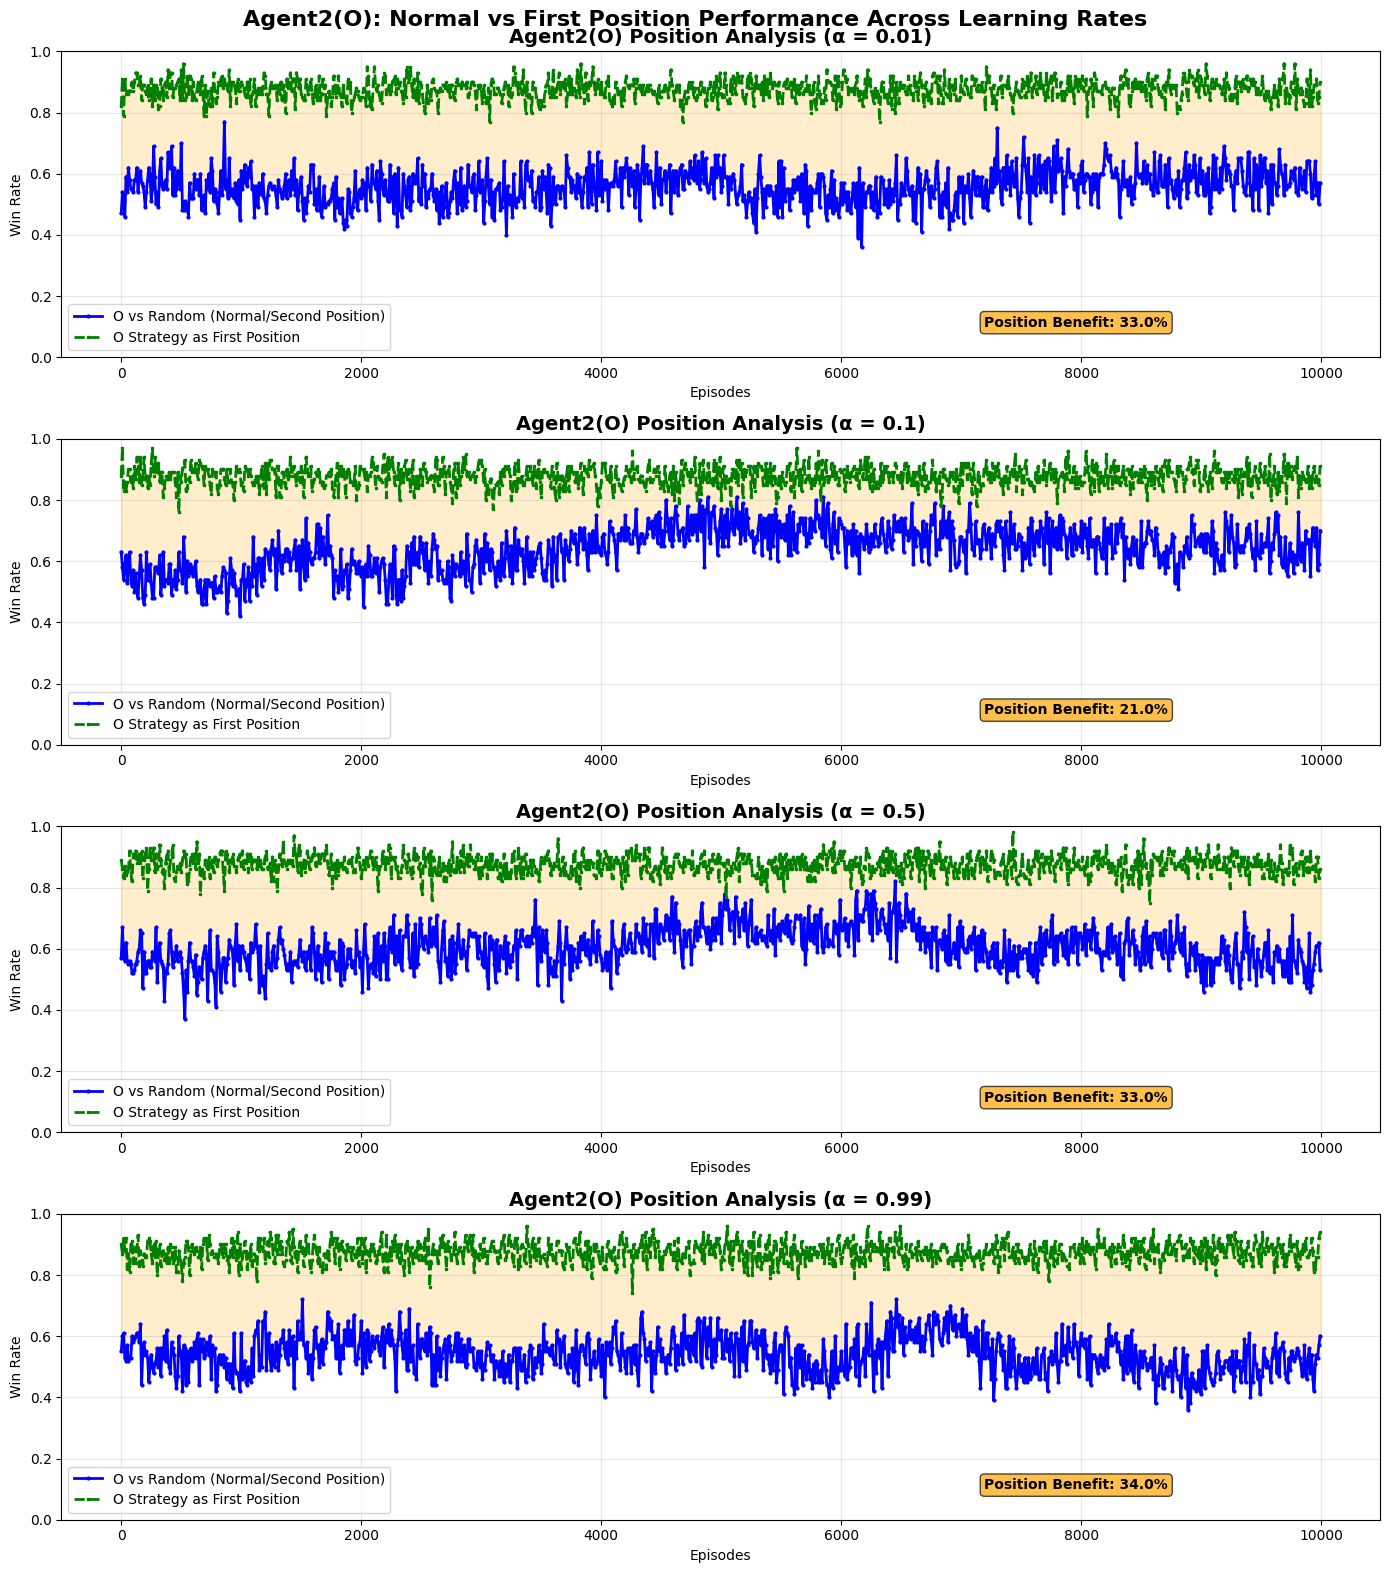

In [ ]:
# Agent2(O) Position Comparison: Normal vs First Position
fig2, ax2 = plt.subplots(4, 1, figsize=(14, 16))

for row, alpha in enumerate(alpha_values):
    data = all_results[alpha]['evaluation_data']
    
    # Blue line: O playing normal position (second)
    ax2[row].plot(data[0], data[4], color='blue', linewidth=2, 
                  label='O vs Random (Normal/Second Position)', marker='o', markersize=2)
    
    # Green line: O strategy playing first position  
    ax2[row].plot(data[0], data[8], color='green', linewidth=2, linestyle='--',
                  label='O Strategy as First Position', marker='s', markersize=2)
    
    # Fill area to show advantage
    ax2[row].fill_between(data[0], data[8], data[4], alpha=0.2, color='orange')
    
    ax2[row].set_title(f'Agent2(O) Position Analysis (α = {alpha})', fontsize=14, fontweight='bold')
    ax2[row].set_xlabel('Episodes')
    ax2[row].set_ylabel('Win Rate')
    ax2[row].grid(True, alpha=0.3)
    ax2[row].set_ylim(0, 1)
    ax2[row].legend()
    
    # Add final advantage annotation
    final_normal = data[4][-1]  # O normal position
    final_first = data[8][-1]   # O as first position
    advantage = final_first - final_normal
    
    ax2[row].annotate(f'Position Benefit: {advantage:.1%}', 
                     xy=(0.7, 0.1), xycoords='axes fraction',
                     bbox=dict(boxstyle='round,pad=0.3', facecolor='orange', alpha=0.7),
                     fontsize=10, fontweight='bold')

plt.suptitle('Agent2(O): Normal vs First Position Performance Across Learning Rates', 
            fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()